# Deep Learning Challenge
## Michelle Rohrer

### Forschungsfrage: Macht es einen Unterschied, ob beim Training die Bilder gedreht, gespiegelt oder verzerrt werden?

### Pakete laden

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from PIL import Image
from collections import defaultdict
from dotenv import load_dotenv

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


load_dotenv()
api_key = os.getenv('API')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignoriert die Warnungne
if api_key:
    print("API Key erfolgreich geladen")
else:
    print("API Key nicht gefunden")

API Key erfolgreich geladen


### Daten laden und vorbereiten
Die Daten wurden von kaggle heruntergeladen (https://www.kaggle.com/datasets/msambare/fer2013)

Infos zu den Daten:

Die Daten bestehen aus 48x48 Pixel großen Graustufenbildern von Gesichtern. Die Gesichter wurden automatisch so ausgerichtet, dass sie mehr oder weniger zentriert sind und ungefähr den gleichen Bereich in jedem Bild einnehmen.

Die Aufgabe besteht darin, jedes Gesicht anhand des im Gesichtsausdruck gezeigten Gefühls einer von sieben Kategorien zuzuordnen (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). Der Trainingssatz besteht aus 28.709 Beispielen und der öffentliche Testsatz aus 3.589 Beispielen.

In [4]:
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

In [5]:
img_size = 48
batch_size = 64

# Daten normalisieren und Validation Split hinzufügen
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% für Validierung
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # 80% der Daten
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 20% der Daten
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

print(f"Klassen: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22968
Validation samples: 5741
Test samples: 7178


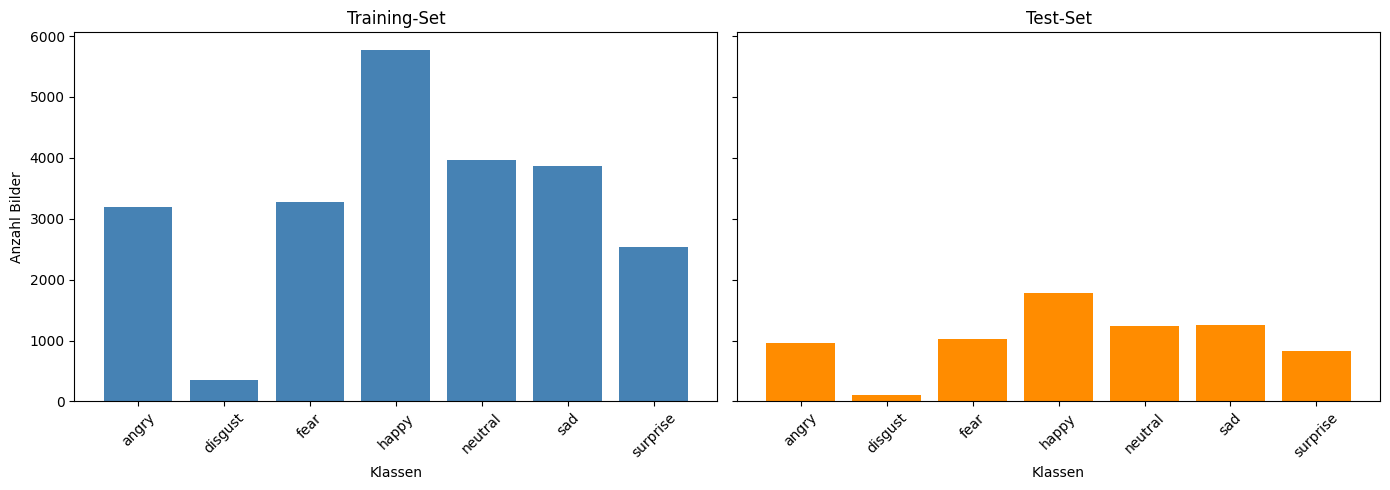

In [6]:
# Barplot mit der Verteilung der Klassen
labels, counts = zip(*[(k, v) for k, v in train_generator.class_indices.items()])
train_labels = train_generator.classes  # numerische Klassenlabels für alle Trainingsbilder
train_df = pd.Series(train_labels).value_counts().sort_index()
class_names = list(train_generator.class_indices.keys())

labels, counts = zip(*[(k, v) for k, v in test_generator.class_indices.items()])
test_labels = test_generator.classes  # numerische Klassenlabels für alle Trainingsbilder
test_df = pd.Series(test_labels).value_counts().sort_index()
class_names = list(test_generator.class_indices.keys())

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

# Training-Set
axes[0].bar(class_names, train_df.values, color="steelblue")
axes[0].set_title("Training-Set")
axes[0].set_xlabel("Klassen")
axes[0].set_ylabel("Anzahl Bilder")
axes[0].tick_params(axis='x', rotation=45)

# Test-Set
axes[1].bar(class_names, test_df.values, color="darkorange")
axes[1].set_title("Test-Set")
axes[1].set_xlabel("Klassen")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

>Man erkennt, dass die Verteilung der Klassen nicht balanciert ist. Es gibt weniger Bilder für die Klasse *"disgust"* als alle anderen. Die Klasse *"happy* ist am häufigsten vertreten.

Bilder ausgewertet (Train): 3949
Bilder ausgewertet (Test): 3711


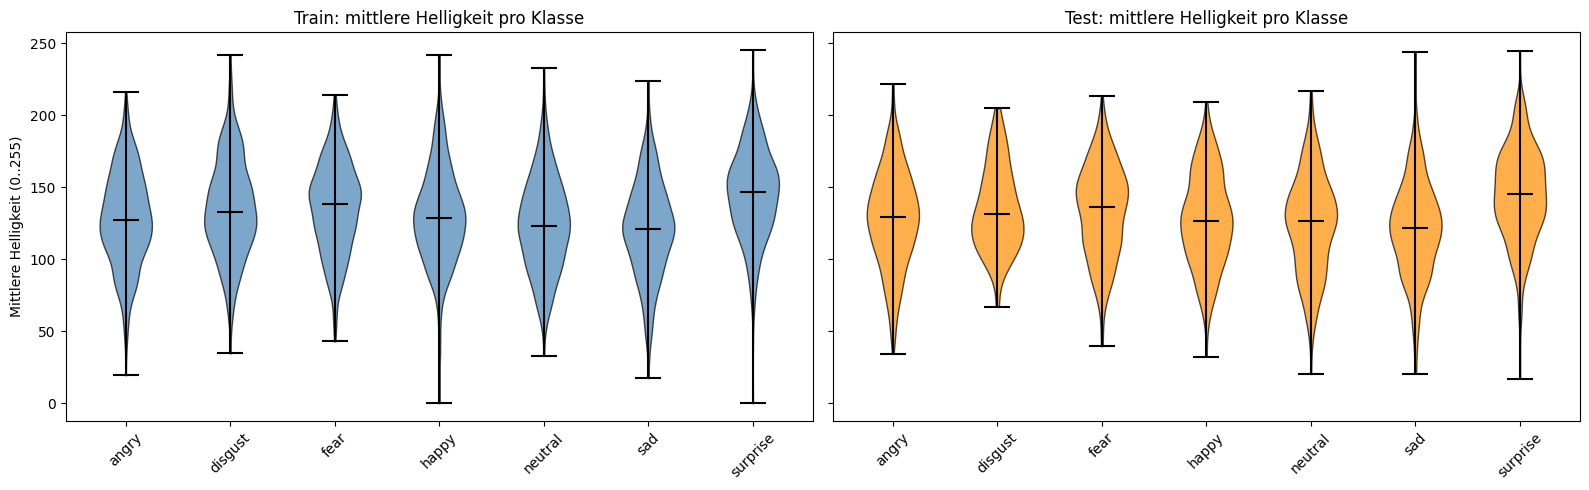

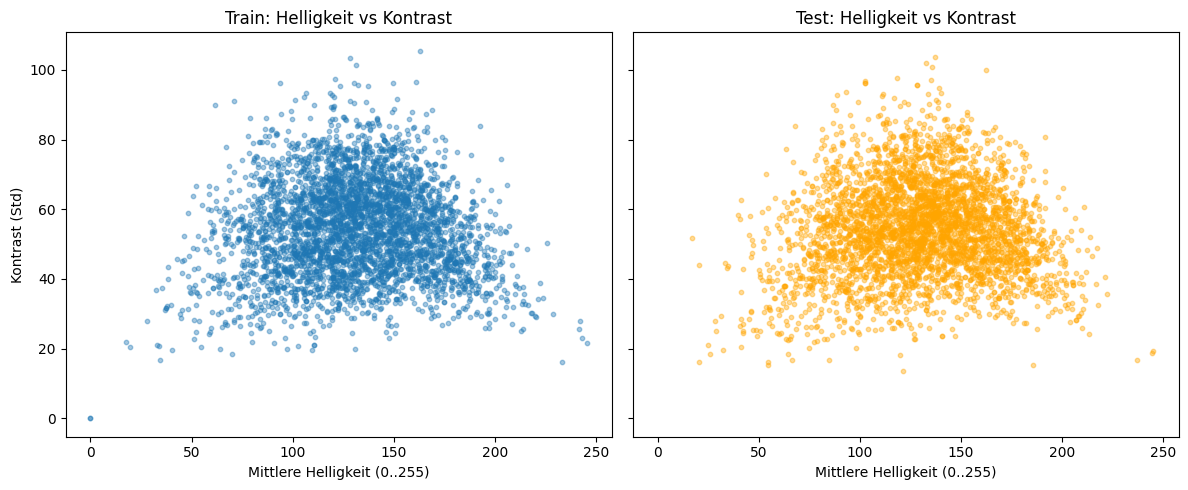

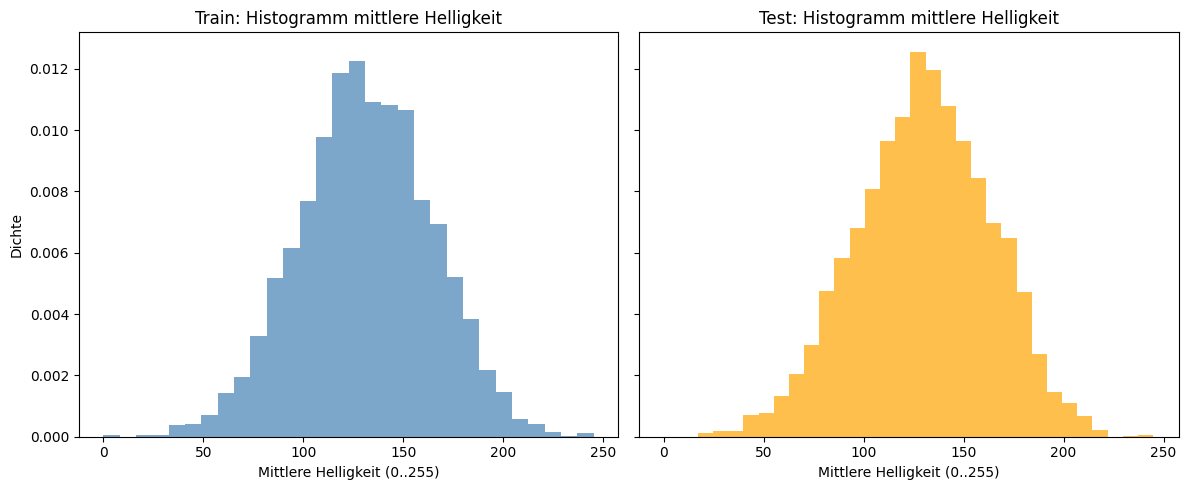

In [7]:
# prüfen, ob die Helligkeit der Bilder gleich ist oder Daten standardisiert werden müssen
def _to_gray_array(path):
    img = Image.open(path).convert("L")  # L = grayscale
    arr = np.asarray(img, dtype=np.float32)
    return arr

def brightness_stats_by_class(generator, max_per_class=500):
    """
    Ermittelt pro Bild: mean (Helligkeit) und std (Kontrast), gruppiert nach Klasse.
    max_per_class limitiert die Anzahl pro Klasse (gleichmäßig sampeln).
    """
    # Klassen-Namen & Indizes
    idx2class = {v:k for k,v in generator.class_indices.items()}
    y = generator.classes
    filepaths = np.array(generator.filepaths)

    # Indizes pro Klasse sammeln
    class_to_indices = defaultdict(list)
    for i, yi in enumerate(y):
        class_to_indices[yi].append(i)

    # gleichmäßiges Sampling
    stats = []  # (class_idx, class_name, mean, std)
    for ci, inds in class_to_indices.items():
        inds = np.array(inds)
        if len(inds) > max_per_class:
            # gleichmäßig ziehen statt rein zufällig
            sel = np.linspace(0, len(inds)-1, max_per_class, dtype=int)
            inds = inds[sel]
        for idx in inds:
            p = filepaths[idx]
            try:
                arr = _to_gray_array(p)  # 0..255 float
                m = float(arr.mean())
                s = float(arr.std(ddof=0))
                stats.append((ci, idx2class[ci], m, s))
            except Exception as e:
                # Beschädigte Bilder ignorieren (werden in Sanity-Check gesondert erfasst)
                continue

    # in Arrays packen
    class_names = [idx2class[i] for i in sorted(class_to_indices.keys())]
    per_class_means = {cn: [] for cn in class_names}
    per_class_stds  = {cn: [] for cn in class_names}
    all_means, all_stds = [], []
    for ci, cname, m, s in stats:
        per_class_means[cname].append(m)
        per_class_stds[cname].append(s)
        all_means.append(m); all_stds.append(s)

    return {
        "class_names": class_names,
        "per_class_means": per_class_means,
        "per_class_stds": per_class_stds,
        "all_means": np.array(all_means),
        "all_stds": np.array(all_stds),
        "n_images": len(all_means)
    }

# Helligkeits-/Kontrast-Statistiken für Train und Test
train_stats = brightness_stats_by_class(train_generator, max_per_class=600)
test_stats  = brightness_stats_by_class(test_generator,  max_per_class=600)

print(f"Bilder ausgewertet (Train): {train_stats['n_images']}")
print(f"Bilder ausgewertet (Test): {test_stats['n_images']}")

# Plots nebeneinander
fig, axes = plt.subplots(1, 2, figsize=(16,5), sharey=True)

# Violinplot mittlere Helligkeit
data_train = [train_stats["per_class_means"][c] for c in train_stats["class_names"]]
data_test  = [test_stats["per_class_means"][c]  for c in test_stats["class_names"]]

# Train
vp_train = axes[0].violinplot(data_train, showmedians=True)
for pc in vp_train['bodies']:
    pc.set_facecolor("steelblue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.7)

# vorhandene Linien einfärben
for partname in ('cmedians','cmeans','cmins','cmaxes','cbars'):
    if partname in vp_train:
        vp_train[partname].set_edgecolor("black")

axes[0].set_title("Train: mittlere Helligkeit pro Klasse")
axes[0].set_xticks(range(1, len(train_stats["class_names"])+1))
axes[0].set_xticklabels(train_stats["class_names"], rotation=45)
axes[0].set_ylabel("Mittlere Helligkeit (0..255)")

# Test
vp_test = axes[1].violinplot(data_test, showmedians=True)
for pc in vp_test['bodies']:
    pc.set_facecolor("darkorange")
    pc.set_edgecolor("black")
    pc.set_alpha(0.7)

for partname in ('cmedians','cmeans','cmins','cmaxes','cbars'):
    if partname in vp_test:
        vp_test[partname].set_edgecolor("black")

axes[1].set_title("Test: mittlere Helligkeit pro Klasse")
axes[1].set_xticks(range(1, len(test_stats["class_names"])+1))
axes[1].set_xticklabels(test_stats["class_names"], rotation=45)

plt.tight_layout()
plt.show()


# Scatter: Helligkeit vs Kontrast
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

axes[0].scatter(train_stats["all_means"], train_stats["all_stds"], s=10, alpha=0.4)
axes[0].set_title("Train: Helligkeit vs Kontrast")
axes[0].set_xlabel("Mittlere Helligkeit (0..255)")
axes[0].set_ylabel("Kontrast (Std)")

axes[1].scatter(test_stats["all_means"], test_stats["all_stds"], s=10, alpha=0.4, color="orange")
axes[1].set_title("Test: Helligkeit vs Kontrast")
axes[1].set_xlabel("Mittlere Helligkeit (0..255)")

plt.tight_layout()
plt.show()

# Histogramm mittlere Helligkeit
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

axes[0].hist(train_stats["all_means"], bins=30, density=True, alpha=0.7, color="steelblue")
axes[0].set_title("Train: Histogramm mittlere Helligkeit")
axes[0].set_xlabel("Mittlere Helligkeit (0..255)")
axes[0].set_ylabel("Dichte")

axes[1].hist(test_stats["all_means"], bins=30, density=True, alpha=0.7, color="orange")
axes[1].set_title("Test: Histogramm mittlere Helligkeit")
axes[1].set_xlabel("Mittlere Helligkeit (0..255)")

plt.tight_layout()
plt.show()

Ich werde die Daten nicht standadisieren
Eventuell Grafiken wieder löschen

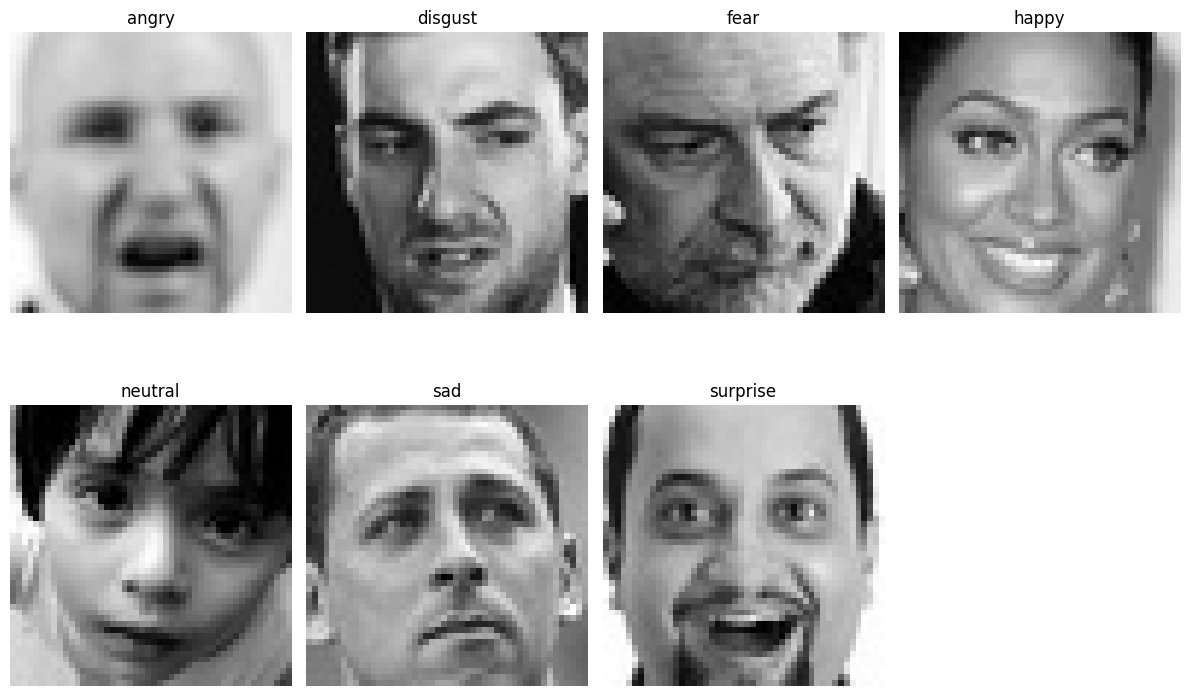

In [8]:
# Beispielbild jeder KLasse
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names):
    # Index des ersten Bildes mit dieser Klasse finden
    idx = np.where(train_generator.classes == train_generator.class_indices[class_name])[0][0]
    img_path = train_generator.filepaths[idx]

    # Bild laden
    img = plt.imread(img_path)

    # Bild anzeigen in Grau
    plt.subplot(2, 4, i+1) 
    plt.imshow(img, cmap="gray")
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

Metriken
- Konfusion-Matrix: Accuracy, Precision, Recall
- F1-Score
- Top-K Accuracy
-> Metriken mit gewichteten Klassen

-> Cross validation, kein GridSearch für den Anfang, wenn ich das ändere was verändert sich, viel vergleichen, was sehe ich, passt das zu den Erwartungen, brauche noch Val Set, denk dran auf GPU laufen lassen, Funktion für vergleiche erstellen, Training auch in anderem Notebook machen, pkl Dateien speichern, Main reicht er wird es nicht laufen lassen

### Basismodell
Als Basismodell wird ein einfaches Convolutional Neural Network (CNN) verwendet.

Ein CNN hat hidden layers, die aus Convolutional Layers bestehen. Diese Convolutional Layers extrahieren Features aus dem Bild. Haben auch non Convolutional Layers, die Basis stellen aber die CNN Layers da.
Die sogenannten Filter identifizieren die Features aus dem Bild. Verschiedene Filter identifizieren verschiedene Features in einem Bild. Geometrische Filter sind am Anfang, je mehr Layer desto detailreicher werden diese Filter. 3x3 Matrizen für Filter sind meist der Standard, also es werden 3x3 vom Input mit der Matrix gerechnet und dieser Wert ist dann der neue Pixelwert. Das wird mit jedem 3x3 Pixel gemacht, also dieser Filter wandert dann immer weiter.
Durch diese Filter werden z.B waagerechte Streifen sichtbar im Bild.

was möchte ich für das Basismodell?
- 3x3 Filter
- 3 Conv-Schichten
- Pooling?
- Dropout?
- learning_rate verschieden vergleichen
- ReLu
- Loss Function?
- unbalancierte Klassen schon berücksichtigen?

In [ ]:
# Wandb Projekt initialisieren
num_classes = len(train_generator.class_indices)

wandb.init(
    project="DEL",
    name="baseline-cnn",
    config={
        "img_size": img_size,
        "batch_size": batch_size,
        "num_classes": num_classes,
        "architecture": "baseline_cnn",
        "optimizer": "sgd",
        "loss": "categorical_crossentropy",
        "filters": [16, 32, 64],
        "dense_units": 64
    }
)

config = wandb.config

In [ ]:
# BASIS-CNN MODELL
def create_baseline_cnn(img_size=48, num_classes=7):
    """
    Erstellt ein einfaches CNN als Baseline-Modell.
    """
    model = models.Sequential([
        # === FEATURE EXTRAKTION ===
        layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            activation='relu',
            input_shape=(img_size, img_size, 1)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            activation='relu'
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            activation='relu'
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        # === KLASSIFIKATION ===
        layers.Flatten(),
        layers.Dense(
            units=64,
            activation='relu'
        ),
        layers.Dense(
            units=num_classes,
            activation='softmax'
        )
    ])
    return model

# Modell erstellen
num_classes = len(train_generator.class_indices)
model = create_baseline_cnn(img_size=config.img_size, num_classes=config.num_classes)

# Kompilieren
model.compile(
    optimizer=config.optimizer,
    loss=config.loss,
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,271 (669.03 KB)

 Trainable params: 171,271 (669.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Wandb Callbacks
callbacks = [
    WandbMetricsLogger(log_freq="epoch"),  # Metriken loggen
    WandbModelCheckpoint("models/best_model.h5")  # Beste Modelle speichern
]

# Training starten
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

# Wandb Run beenden
wandb.finish()